In [1]:
import torch
import torchvision
import matplotlib
print("torch version: ",torch.__version__)
print("torchvision version: ",torchvision.__version__)
print("cuda available: ", torch.cuda.is_available())
print("matplotlib version", matplotlib.__version__)

torch version:  2.0.1
torchvision version:  0.15.2
cuda available:  True
matplotlib version 3.8.2


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
from utils.mydataset import MyDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from torchvision.io import read_image

transform = transforms.Compose([
    transforms.Resize((256,256)),
])

test_dataset = MyDataset(input_folder="test",truth_folder="test_truth",transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [4]:
# 检查CUDA是否可用，并设置默认设备
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA on GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")


Using CUDA on GPU: NVIDIA GeForce RTX 2070 with Max-Q Design


In [5]:
test_dataset.__len__()

400

4062.jpg


e:\anaconda3\envs\inpainting-basic\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


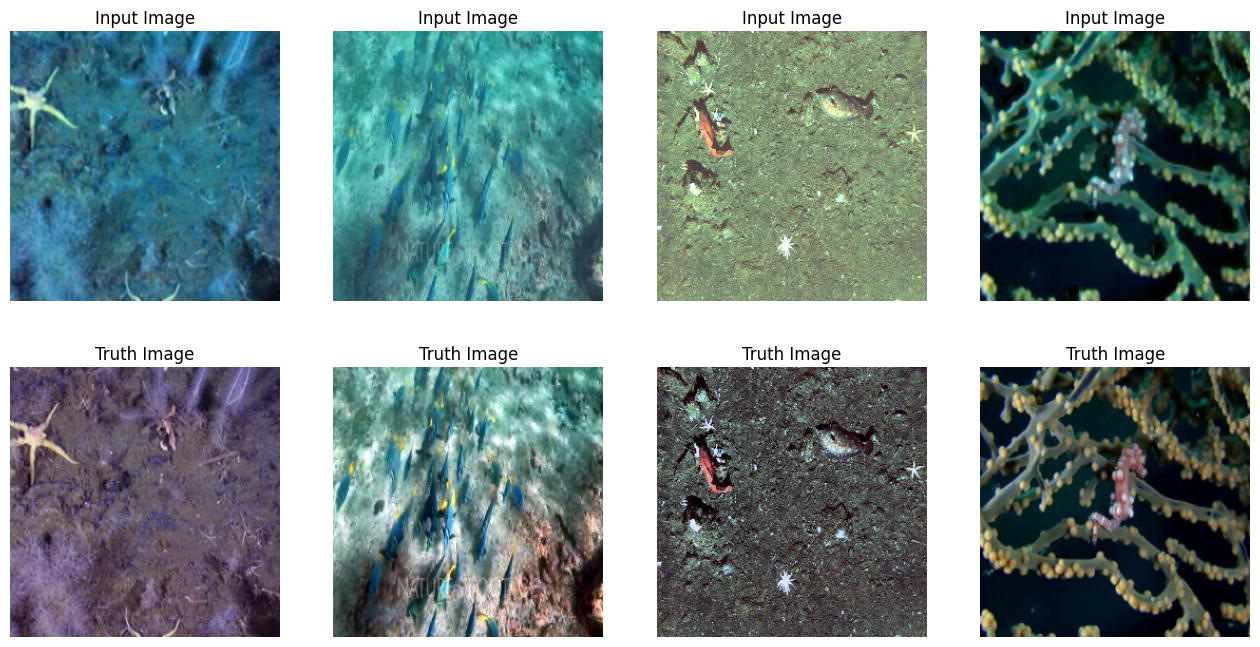

tensor([[[0.1426, 0.1270, 0.1784,  ..., 0.1289, 0.1265, 0.1431],
         [0.1586, 0.1292, 0.1851,  ..., 0.1205, 0.1136, 0.1258],
         [0.1826, 0.1398, 0.1796,  ..., 0.1262, 0.1189, 0.1306],
         ...,
         [0.3978, 0.3392, 0.2953,  ..., 0.0357, 0.0336, 0.0366],
         [0.3544, 0.3161, 0.2876,  ..., 0.0373, 0.0384, 0.0478],
         [0.3304, 0.3010, 0.2814,  ..., 0.0328, 0.0451, 0.0647]],

        [[0.3162, 0.3118, 0.3804,  ..., 0.3108, 0.3132, 0.3314],
         [0.3322, 0.3127, 0.3835,  ..., 0.2952, 0.2932, 0.3069],
         [0.3491, 0.3144, 0.3689,  ..., 0.2837, 0.2813, 0.2974],
         ...,
         [0.5192, 0.5021, 0.5088,  ..., 0.0437, 0.0375, 0.0405],
         [0.4750, 0.4749, 0.5052,  ..., 0.0412, 0.0424, 0.0517],
         [0.4510, 0.4598, 0.4990,  ..., 0.0368, 0.0490, 0.0686]],

        [[0.3681, 0.3691, 0.4353,  ..., 0.3961, 0.3740, 0.3794],
         [0.3841, 0.3700, 0.4384,  ..., 0.3912, 0.3602, 0.3585],
         [0.4044, 0.3751, 0.4271,  ..., 0.3899, 0.3601, 0.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 从数据加载器中获取一个批次的图像
dataiter = iter(test_loader)
images, groundtruth, file_name = next(dataiter)

print(file_name[0])
# 显示批次中的前几个图像对
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i in range(4):
    ax[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax[0, i].set_title('Input Image')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(np.transpose(groundtruth[i].numpy(), (1, 2, 0)))
    ax[1, i].set_title('Truth Image')
    ax[1, i].axis('off')
plt.show()

print(images[0])



In [7]:
from network.network import SimpleAutoencoder
model = SimpleAutoencoder()
model.load_state_dict(torch.load("weights\model_epoch_10.pth"))
model = model.to("cpu")
model.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [8]:
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# 假设MyDataset类已经正确定义并可以返回文件名
# 假设model已经被正确加载和设置为评估模式

# 初始化PSNR值列表
psnr_values = []

# 遍历测试数据集
for images, groundtruth, file_names in test_loader:
    # images, groundtruth = images.to(device), groundtruth.to(device)
    
    # 使用模型进行预测
    with torch.no_grad():  # 确保在此过程中不会计算梯度
        outputs = model(images)
    
    # 计算每个图像对的PSNR值
    for i in range(images.size(0)):
        # 将预测和真实图像转换为相同的数据范围，如果已经是，请忽略此步
        output = outputs[i].cpu().numpy()
        gt = groundtruth[i].cpu().numpy()
        
        # 计算PSNR
        psnr_value = psnr(gt, output, data_range=gt.max() - gt.min())
        psnr_values.append(psnr_value)
        
        print(f"File: {file_names[i]}, PSNR: {psnr_value:.2f}")

# 计算整个测试集的平均PSNR
average_psnr = sum(psnr_values) / len(psnr_values)
print(f"Average PSNR over the test set: {average_psnr:.2f}")


e:\anaconda3\envs\inpainting-basic\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


File: 1050.jpg, PSNR: 18.04
File: 2053.jpg, PSNR: 21.37
File: 3064.jpg, PSNR: 23.39
File: 3018.jpg, PSNR: 24.00
File: 2075.jpg, PSNR: 21.72
File: 1057.jpg, PSNR: 20.50
File: 3033.jpg, PSNR: 23.56
File: 4037.jpg, PSNR: 22.45
File: 4064.jpg, PSNR: 23.33
File: 2057.jpg, PSNR: 20.91
File: 4030.jpg, PSNR: 23.15
File: 1032.jpg, PSNR: 19.07
File: 1047.jpg, PSNR: 17.47
File: 1022.jpg, PSNR: 18.52
File: 4031.jpg, PSNR: 22.78
File: 2047.jpg, PSNR: 23.65
File: 2070.jpg, PSNR: 20.15
File: 2069.jpg, PSNR: 16.34
File: 3038.jpg, PSNR: 22.94
File: 2039.jpg, PSNR: 22.99
File: 3027.jpg, PSNR: 22.32
File: 2998.jpg, PSNR: 21.48
File: 1009.jpg, PSNR: 19.10
File: 1014.jpg, PSNR: 13.95
File: 1037.jpg, PSNR: 17.53
File: 4073.jpg, PSNR: 21.98
File: 4932.jpg, PSNR: 21.53
File: 4040.jpg, PSNR: 23.73
File: 4016.jpg, PSNR: 26.98
File: 3007.jpg, PSNR: 22.24
File: 3096.jpg, PSNR: 23.64
File: 1039.jpg, PSNR: 17.10
File: 3036.jpg, PSNR: 19.73
File: 1015.jpg, PSNR: 16.90
File: 4048.jpg, PSNR: 23.32
File: 3020.jpg, PSNR

In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# 假设MyDataset类已经正确定义并可以返回文件名
# 假设model已经被正确加载和设置为评估模式

# 初始化PSNR值列表
psnr_values = []

# 遍历测试数据集
for images, groundtruth, file_names in test_loader:
    # images, groundtruth = images.to(device), groundtruth.to(device)
    
    # 使用模型进行预测
    with torch.no_grad():  # 确保在此过程中不会计算梯度
        outputs = images
    
    # 计算每个图像对的PSNR值
    for i in range(images.size(0)):
        # 将预测和真实图像转换为相同的数据范围，如果已经是，请忽略此步
        output = outputs[i].cpu().numpy()
        gt = groundtruth[i].cpu().numpy()
        
        # 计算PSNR
        psnr_value = psnr(gt, output)
        psnr_values.append(psnr_value)
        
        print(f"File: {file_names[i]}, PSNR: {psnr_value:.2f}")

# 计算整个测试集的平均PSNR
average_psnr = sum(psnr_values) / len(psnr_values)
print(f"Average PSNR over the test set: {average_psnr:.2f}")


File: 1983.jpg, PSNR: 16.96
File: 4084.jpg, PSNR: 16.48
File: 4068.jpg, PSNR: 17.57
File: 1984.jpg, PSNR: 16.29
File: 1094.jpg, PSNR: 15.04
File: 1102.jpg, PSNR: 10.13
File: 4928.jpg, PSNR: 14.62
File: 3059.jpg, PSNR: 19.49
File: 4049.jpg, PSNR: 17.93
File: 1025.jpg, PSNR: 11.75
File: 1014.jpg, PSNR: 11.46
File: 1088.jpg, PSNR: 13.07
File: 4040.jpg, PSNR: 20.34
File: 3060.jpg, PSNR: 19.16
File: 4089.jpg, PSNR: 21.01
File: 3038.jpg, PSNR: 20.14
File: 3065.jpg, PSNR: 20.10
File: 4927.jpg, PSNR: 14.46
File: 4083.jpg, PSNR: 19.95
File: 4018.jpg, PSNR: 22.25
File: 1008.jpg, PSNR: 15.08
File: 1097.jpg, PSNR: 13.11
File: 3998.jpg, PSNR: 20.36
File: 3034.jpg, PSNR: 18.81
File: 4050.jpg, PSNR: 22.61
File: 2069.jpg, PSNR: 15.96
File: 4073.jpg, PSNR: 21.06
File: 2065.jpg, PSNR: 23.92
File: 1106.jpg, PSNR: 14.87
File: 2049.jpg, PSNR: 18.57
File: 3036.jpg, PSNR: 21.63
File: 3082.jpg, PSNR: 22.11
File: 3057.jpg, PSNR: 18.99
File: 3046.jpg, PSNR: 17.49
File: 1093.jpg, PSNR: 11.10
File: 2046.jpg, PSNR

In [12]:
print(output[1])

[[1.         0.9941176  0.9941176  ... 0.3745098  0.32156864 0.39019608]
 [0.9901961  0.99803925 0.99607843 ... 0.3647059  0.36862746 0.3647059 ]
 [1.         1.         1.         ... 0.39803922 0.42745098 0.3647059 ]
 ...
 [0.62352943 0.49411768 0.38039216 ... 0.39803922 0.38431373 0.5117647 ]
 [0.4117647  0.41764706 0.43137255 ... 0.47058824 0.41960785 0.4372549 ]
 [0.44705883 0.4784314  0.44117647 ... 0.5137255  0.46862745 0.4745098 ]]


In [13]:
import math


def compute_psnr(img1, img2):
   mse = np.mean( (img1 - img2) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [14]:
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# 假设MyDataset类已经正确定义并可以返回文件名
# 假设model已经被正确加载和设置为评估模式

# 初始化PSNR值列表
psnr_values = []

# 遍历测试数据集
for images, groundtruth, file_names in test_loader:
    # images, groundtruth = images.to(device), groundtruth.to(device)
    
    # 使用模型进行预测
    with torch.no_grad():  # 确保在此过程中不会计算梯度
        outputs = images
    
    # 计算每个图像对的PSNR值
    for i in range(images.size(0)):
        # 将预测和真实图像转换为相同的数据范围，如果已经是，请忽略此步
        output = outputs[i].cpu().numpy()
        gt = groundtruth[i].cpu().numpy()
        
        # 计算PSNR
        psnr_value = compute_psnr(gt, output)
        psnr_values.append(psnr_value)
        
        print(f"File: {file_names[i]}, PSNR: {psnr_value:.2f}")

# 计算整个测试集的平均PSNR
average_psnr = sum(psnr_values) / len(psnr_values)
print(f"Average PSNR over the test set: {average_psnr:.2f}")


e:\anaconda3\envs\inpainting-basic\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


File: 3088.jpg, PSNR: 19.49
File: 3095.jpg, PSNR: 20.07
File: 1015.jpg, PSNR: 17.57
File: 4025.jpg, PSNR: 16.33
File: 3059.jpg, PSNR: 19.49
File: 3035.jpg, PSNR: 19.90
File: 1041.jpg, PSNR: 13.96
File: 4089.jpg, PSNR: 21.01
File: 1985.jpg, PSNR: 15.88
File: 2061.jpg, PSNR: 16.52
File: 1978.jpg, PSNR: 21.96
File: 1063.jpg, PSNR: 17.04
File: 5038.jpg, PSNR: 16.90
File: 1050.jpg, PSNR: 13.89
File: 3044.jpg, PSNR: 17.80
File: 4061.jpg, PSNR: 17.69
File: 3043.jpg, PSNR: 16.11
File: 3083.jpg, PSNR: 16.41
File: 1033.jpg, PSNR: 13.52
File: 4948.jpg, PSNR: 17.31
File: 3998.jpg, PSNR: 20.36
File: 4072.jpg, PSNR: 18.39
File: 1034.jpg, PSNR: 12.03
File: 4083.jpg, PSNR: 19.95
File: 2998.jpg, PSNR: 21.74
File: 4088.jpg, PSNR: 20.53
File: 2045.jpg, PSNR: 13.55
File: 4049.jpg, PSNR: 17.93
File: 1042.jpg, PSNR: 16.66
File: 4073.jpg, PSNR: 21.06
File: 2062.jpg, PSNR: 21.09
File: 2041.jpg, PSNR: 23.33
File: 1044.jpg, PSNR: 13.54
File: 3045.jpg, PSNR: 21.22
File: 3017.jpg, PSNR: 21.20
File: 2067.jpg, PSNR